# What is my task?

Well, Mr Cj this time has a new surprise for me ... He want me to predict *Gold Price*, I don't remember being a prophet at all! but since the boss has given orders, there is no choice. Let's get to work!

# Whar do we have?

I searched in google and found [this dataset](https://datahub.io/core/gold-prices#readme): 
* *Monthly gold prices in USD since 1833 (sourced from the World Gold Council). The data is derived from historical records compiled by Timothy Green and supplemented by data provided by the World Bank.*

Im going to download monthly dataset and predict gold price.

# What is my Evaluate metrics?

Our task is not a classification, it is close to a regression task so i'll use metrics such as `Mean Absolute Error`, `Root Mean Square Error`, `Mean Absolute Percentage Error`.

# LETS CoDe!¡

## Download needed files

We need our dataset first, we also download a helper for not coding too much

In [210]:
import requests
import os

def download_and_save(url:str, filename:str): 
    response = requests.get(url)

    with open(filename, "wb") as file:
        file.write(response.content)

In [211]:
if not os.path.isfile("dataset.csv"):
    download_and_save("https://datahub.io/core/gold-prices/_r/-/data/monthly.csv", "dataset.csv")

if not os.path.isfile("helper.py"):
    download_and_save("https://raw.githubusercontent.com/sirUnchained/Machine-Learning-and-Data-Analysis/refs/heads/main/helpers.py", "helper.py")

## Import needed libraries

In [212]:
import tensorflow as tf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path
from sklearn.metrics import (
  mean_squared_error,
  mean_absolute_error, 
  mean_absolute_percentage_error
)

import helper

RANDOM_SEED = 42
BATCH_SIZE = 32
MAX_EPOCHS = 1000
MODEL_SAVE_PATH = Path("./models")
TENSORBOARD_LOG_DIR = Path("./logs")

MODEL_SAVE_PATH.mkdir(exist_ok=True)
TENSORBOARD_LOG_DIR.mkdir(exist_ok=True)

## Data Part!

### Load and analyse dataset
Let's load dataset and set Date column as index:

In [213]:
df = pd.read_csv("./dataset.csv", parse_dates=["Date"], index_col=["Date"])
df

,Price
Date,
1833-01-01,18.93
1833-02-01,18.93
1833-03-01,18.93
1833-04-01,18.93
1833-05-01,18.93
...,...
2025-03-01,2983.25
2025-04-01,3217.64
2025-05-01,3309.49


Good now we can start EDA

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2311 entries, 1833-01-01 to 2025-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2311 non-null   float64
dtypes: float64(1)
memory usage: 36.1 KB


1. We have no missing values and we have 2311 rows, it seems like we have samples untill 2025.
2. We've got only `1` feature for predict which means we have a **Univariate** proble.

Let's setup a funtion for plotting this dataset

In [215]:
def create_time_series_plot(
    timesteps, values, format=".", start=0, end=None, label=None
):
    """
    Plots a timesteps against values (a series of values across timesteps).

    Parameters:
        timesteps : array of timesteps
        values : array of values across time
        format : style of plot, default "."
        start : where to start the plot (setting a value will index from start of timesteps & values)
        end : where to end the plot (setting a value will index from end of timesteps & values)
        label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

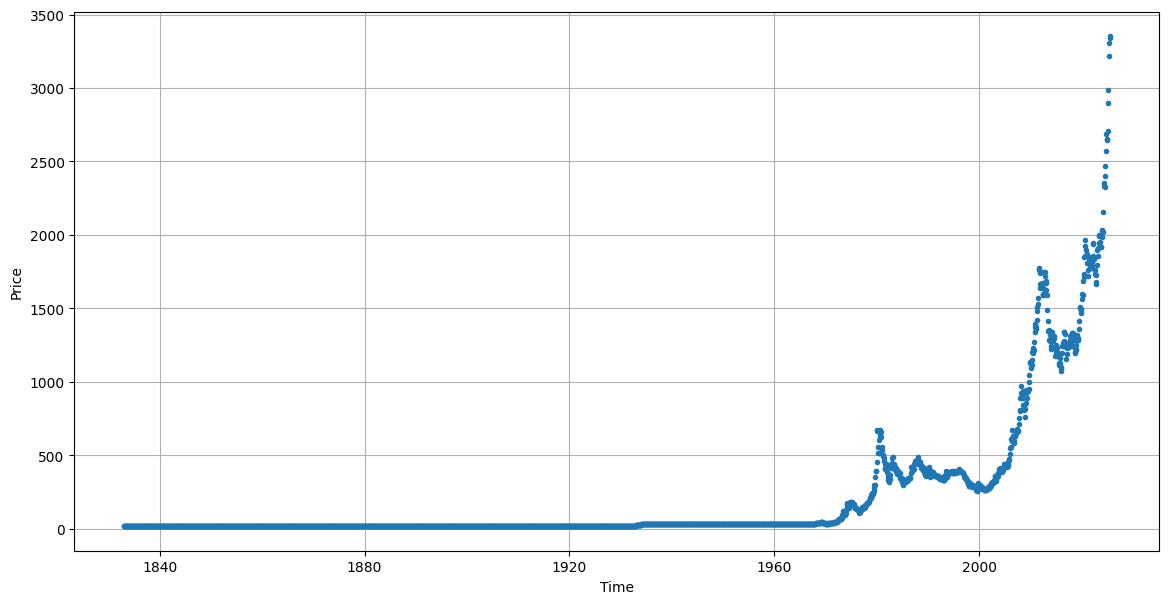

In [216]:
plt.figure(figsize=(14, 7))
create_time_series_plot(df.index.to_numpy(), df.Price)

As i can see there are so amny datas which has value near 0, I want to drop them

In [217]:
df.drop(df.index[0:1000])

,Price
Date,
1916-05-01,18.99
1916-06-01,18.99
1916-07-01,18.99
1916-08-01,18.99
1916-09-01,18.99
...,...
2025-03-01,2983.25
2025-04-01,3217.64
2025-05-01,3309.49


In [218]:
df = df.drop(df.index[0:1000])

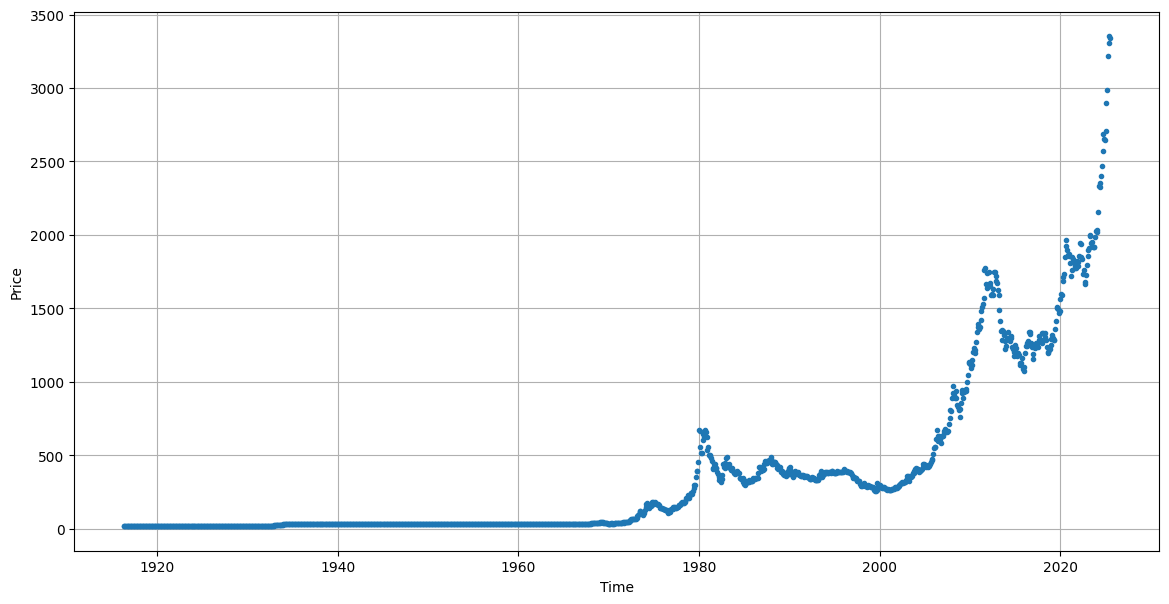

In [219]:
plt.figure(figsize=(14, 7))
create_time_series_plot(df.index.to_numpy(), df.Price)

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1311 entries, 1916-05-01 to 2025-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1311 non-null   float64
dtypes: float64(1)
memory usage: 20.5 KB


better now.

### Train and test split

As you can see, we set newer datas for validation and older data for learn

In [221]:
TRAIN_SIZE = int(len(df) * 0.85)

train_df = df[:TRAIN_SIZE]
test_df = df[TRAIN_SIZE:]

len(train_df), len(test_df)

(1114, 197)

In [222]:
train_df[-5:], test_df[-5:]

(              Price
 Date               
 2008-10-01  806.620
 2008-11-01  760.863
 2008-12-01  816.092
 2009-01-01  858.690
 2009-02-01  943.000,
               Price
 Date               
 2025-03-01  2983.25
 2025-04-01  3217.64
 2025-05-01  3309.49
 2025-06-01  3352.66
 2025-07-01  3340.15)

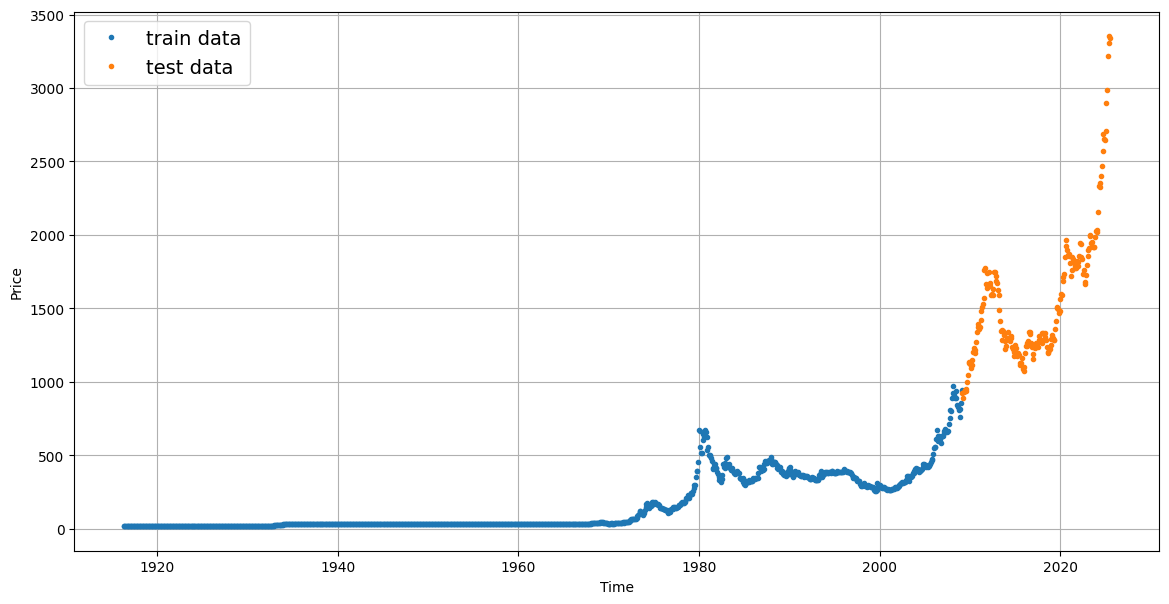

In [223]:
plt.figure(figsize=(14, 7))
create_time_series_plot(train_df.index.to_numpy(), train_df.Price, label="train data")
create_time_series_plot(test_df.index.to_numpy(), test_df.Price, label="test data")

## Model part!

### Setup evaluate metrics

We need an evaluate function with our metrics

In [224]:
def evaluate_preds(y_true, y_pred):
  # Calculate metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  
  return {"Mean Absolute Error": f"{mae:.5f}", "Mean Square Error": f"{mse:.5f}", "Root Mean Square Error": f"{rmse:.5f}", "Mean Absolute Percentage Erorr": f"{mape:.5f}"}

### Setup make window funcrion

I want to create a function for turning my dataset into some `window` and `horizon` 

In [225]:
def make_window_horizon(df: pd.DataFrame, target: str, window: int, horizon: int, batch_size = None):
    """
    This function will turn data into windows and horizons and return both.
    
    params:
        df: Input DataFrame
        target: Column name for the target variable
        window: Number of past timesteps to use as input
        horizon: Number of future timesteps to predict
        batch_size: Number of batches, default is None
    
    return:
        windows: Numpy array of input windows
        horizons: Numpy array of target horizons
        dataset: tf.data.Dataset instance
    """
    # Extract the target series
    series = df[target].values
    
    # Create windows (input features)
    windows = []
    horizons_list = []
    
    # Slide through the series to create windows and horizons
    for i in range(len(series) - window - horizon + 1):
        # Window: from i to i + window
        window_data = series[i:i + window]
        # Horizon: from i + window to i + window + horizon
        horizon_data = series[i + window:i + window + horizon]
        
        windows.append(window_data)
        horizons_list.append(horizon_data)
    
    # Convert to numpy arrays
    windows = np.array(windows)
    horizons = np.array(horizons_list)
    
    # Create the dataset using the same logic but with timeseries_dataset_from_array
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=series[:-horizon],  # Input data stops HORIZON steps before the end
        targets=horizons,  # The horizons we already created
        sequence_length=window,
        sequence_stride=1,
        shuffle=False,
        batch_size=batch_size
    )
    
    return windows, horizons, dataset

### Base Model

For a base line im going to use `Naive forcast` model. This model prediction is simple, the prediction equals to every value excluding the last value

In [226]:
naive_forecast = test_df.Price[:-1]
naive_forecast[:10], naive_forecast[-10:]

(Date
 2009-03-01     924.273
 2009-04-01     890.200
 2009-05-01     928.645
 2009-06-01     945.670
 2009-07-01     934.228
 2009-08-01     949.375
 2009-09-01     996.591
 2009-10-01    1043.159
 2009-11-01    1127.036
 2009-12-01    1134.724
 Name: Price, dtype: float64,
 Date
 2024-09-01    2570.55
 2024-10-01    2690.08
 2024-11-01    2651.13
 2024-12-01    2648.01
 2025-01-01    2709.69
 2025-02-01    2894.73
 2025-03-01    2983.25
 2025-04-01    3217.64
 2025-05-01    3309.49
 2025-06-01    3352.66
 Name: Price, dtype: float64)

Do you understand anything? Let's plot it!

In [227]:
naive_forecast[0]

/tmp/ipykernel_209958/1255303846.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  naive_forecast[0]


np.float64(924.273)

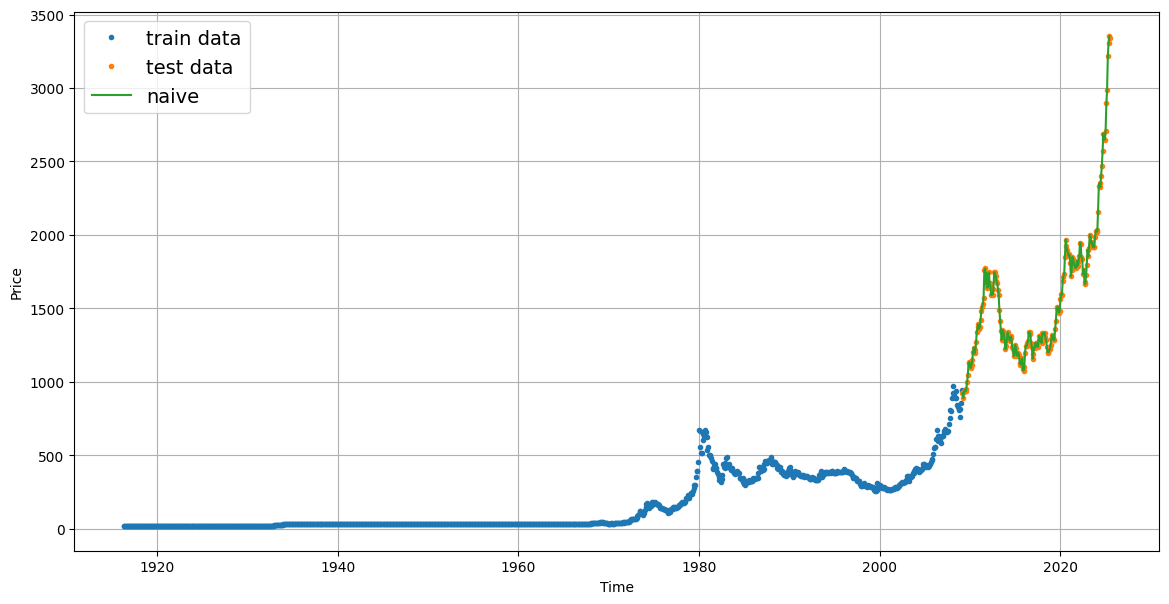

In [228]:
plt.figure(figsize=(14, 7))
create_time_series_plot(train_df.index.to_numpy(), train_df.Price, label="train data")
create_time_series_plot(test_df.index.to_numpy(), test_df.Price, label="test data")
create_time_series_plot(naive_forecast.index.to_numpy(), naive_forecast, label="naive", format="-")

In [229]:
baseline = evaluate_preds(test_df.Price[1:], naive_forecast)
baseline

{'Mean Absolute Error': '42.47791',
 'Mean Square Error': '3199.04722',
 'Root Mean Square Error': '56.56012',
 'Mean Absolute Percentage Erorr': '0.02676'}

It is going to be hard to beat this one!

### Dense Model

#### Setup datas

Let's first turn our dataframe into tensorflow dataset:

In [230]:
MODEL_1_WINDOW = 7
MODEL_1_HORIZON = 1
MODEL_1_NAME = Path("model_1_dense")

train_windows, train_horizons, _ = make_window_horizon(train_df, "Price", MODEL_1_WINDOW, MODEL_1_HORIZON)
test_windows, test_horizons, _ = make_window_horizon(test_df, "Price", MODEL_1_WINDOW, MODEL_1_HORIZON)

#### Setup model architecture

Now we can setup model architecture:

In [231]:
input = tf.keras.layers.Input(shape=(MODEL_1_WINDOW, MODEL_1_HORIZON))
X = tf.keras.layers.Dense(units=128, activation="relu")(input)
out = tf.keras.layers.Dense(units=1, activation="linear")(X)
model = tf.keras.Model(inputs=input, outputs=out)

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 7, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7, 128)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

Now let's setup some models hyperparameters:

In [232]:
loss = tf.keras.losses.MeanAbsoluteError()
optim = tf.keras.optimizers.Adam(learning_rate=5e-5)
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=(TENSORBOARD_LOG_DIR / MODEL_1_NAME)), 
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=0), 
    tf.keras.callbacks.ModelCheckpoint(filepath=(MODEL_SAVE_PATH / f"{MODEL_1_NAME}.keras"))
]

Now time to compile and fit!

In [233]:
model.compile(optimizer=optim, loss=loss, metrics=["mae"])
history = model.fit(
    x=train_windows,
    y=train_horizons, 
    validation_data=(test_windows, test_horizons),
    shuffle=False, 
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS, 
    callbacks=callbacks, 
)

Epoch 1/1000


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 72.2517 - mae: 72.2517 - val_loss: 1934.9840 - val_mae: 1934.9840
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 70.9882 - mae: 70.9882 - val_loss: 1907.6705 - val_mae: 1907.6705
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 69.9734 - mae: 69.9734 - val_loss: 1881.5289 - val_mae: 1881.5289
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 68.9920 - mae: 68.9920 - val_loss: 1855.9451 - val_mae: 1855.9451
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 68.0265 - mae: 68.0265 - val_loss: 1830.6410 - val_mae: 1830.6410
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 67.0704 - mae: 67.0704 - val_loss: 1805.5990 - val_mae: 1805.5990
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 66.1259 - mae: 66.1259 - val_loss: 1780.7632 - val_mae: 1780.7632
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 65.1850 - mae: 65.1850 - val_loss: 1756.0029 - val_mae: 1756.00

In [234]:
model.evaluate(test_windows, test_horizons)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 99.3973 - mae: 99.3973  


[107.99002838134766, 107.99002838134766]

#### Evaluate model

In [255]:
model = tf.keras.models.load_model(MODEL_SAVE_PATH / f"{MODEL_1_NAME}.keras")
model.evaluate(test_windows, test_horizons)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 99.3973 - mae: 99.3973   


[107.99002838134766, 107.99002838134766]

In [262]:
y_preds = np.squeeze(model.predict(test_windows))
y_pred = [num.mean() for num in y_preds]

evaluate_preds(test_horizons, y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


{'Mean Absolute Error': '98.16286',
 'Mean Square Error': '17843.28950',
 'Root Mean Square Error': '133.57878',
 'Mean Absolute Percentage Erorr': '0.05829'}

In [263]:
baseline

{'Mean Absolute Error': '42.47791',
 'Mean Square Error': '3199.04722',
 'Root Mean Square Error': '56.56012',
 'Mean Absolute Percentage Erorr': '0.02676'}

#### Let's plot results

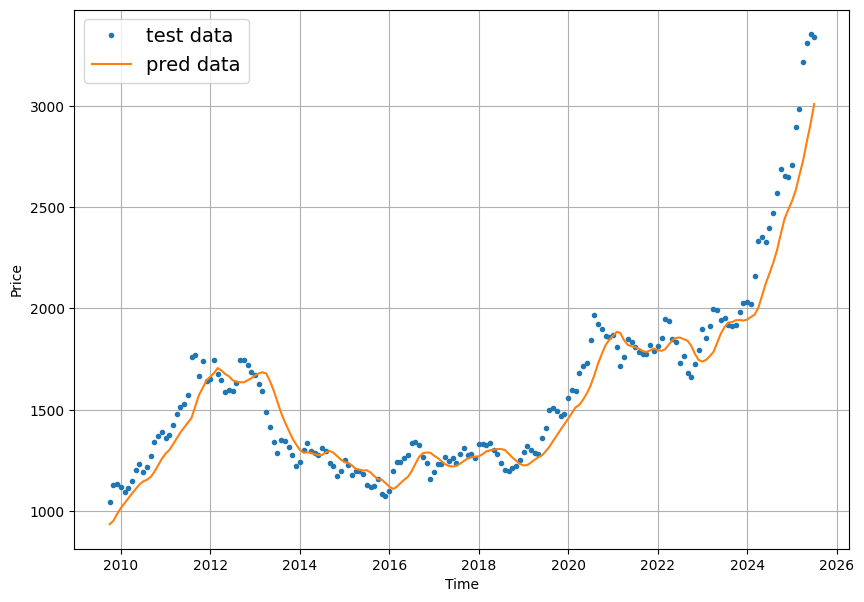

In [264]:
offset = 0
plt.figure(figsize=(10, 7))

create_time_series_plot(timesteps=test_df.index[-len(test_windows):], values=test_horizons[:, 0], start=offset, format='.', label="test data")
create_time_series_plot(timesteps=test_df.index[-len(test_windows):], values=y_pred, start=offset, format='-', label="pred data")


In [239]:
y_preds[-5:], test_horizons[-5:]

(array([[2463.4397, 2563.563 , 2682.7634, 2643.9207, 2640.8093, 2702.319 ,
         2886.8489],
        [2563.563 , 2682.7634, 2643.9207, 2640.8093, 2702.319 , 2886.8489,
         2975.1245],
        [2682.7634, 2643.9207, 2640.8093, 2702.319 , 2886.8489, 2975.1245,
         3208.8682],
        [2643.9207, 2640.8093, 2702.319 , 2886.8489, 2975.1245, 3208.8682,
         3300.465 ],
        [2640.8093, 2702.319 , 2886.8489, 2975.1245, 3208.8682, 3300.465 ,
         3343.5159]], dtype=float32),
 array([[2983.25],
        [3217.64],
        [3309.49],
        [3352.66],
        [3340.15]]))

SO CLOSE! ok ok I shall test more hyper parameters but now lemme use RNN layers!

### RNN Model

#### Setup datas

Let's first turn our dataframe into tensorflow dataset:

In [240]:
MODEL_2_WINDOW = 7
MODEL_2_HORIZON = 1
MODEL_2_NAME = Path("model_2_rnn")

train_windows, train_horizons, train_ds = make_window_horizon(train_df, "Price", MODEL_2_WINDOW, MODEL_2_HORIZON)
test_windows, test_horizons, test_ds = make_window_horizon(test_df, "Price", MODEL_2_WINDOW, MODEL_2_HORIZON)

#### Setup model architecture

Now we can setup model architecture:

In [244]:
input = tf.keras.layers.Input(shape=(MODEL_2_WINDOW, MODEL_2_HORIZON))
X = tf.keras.layers.GRU(units=128)(input)
out = tf.keras.layers.Dense(units=1, activation="linear")(X)
model = tf.keras.Model(inputs=input, outputs=out)

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 7, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,433 (197.00 KB)

 Trainable params: 50,433 (197.00 KB)

 Non-trainable params: 0 (0.00 B)

Now let's setup some models hyperparameters:

In [245]:
loss = tf.keras.losses.MeanAbsoluteError()
optim = tf.keras.optimizers.Adam(learning_rate=5e-5)
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=(TENSORBOARD_LOG_DIR / MODEL_2_NAME)), 
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=0), 
    tf.keras.callbacks.ModelCheckpoint(filepath=(MODEL_SAVE_PATH / f"{MODEL_2_NAME}.keras"))
]

Now time to compile and fit!

In [246]:
model.compile(optimizer=optim, loss=loss, metrics=["mae"])
history = model.fit(
    x=train_windows,
    y=train_horizons, 
    validation_data=(test_windows, test_horizons),
    shuffle=False, 
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS, 
    callbacks=callbacks, 
)

Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 58.6532 - mae: 58.6532 - val_loss: 1595.9503 - val_mae: 1595.9503
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 58.1205 - mae: 58.1205 - val_loss: 1595.5948 - val_mae: 1595.5948
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 57.6051 - mae: 57.6051 - val_loss: 1595.0808 - val_mae: 1595.0808
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 57.0682 - mae: 57.0682 - val_loss: 1594.8394 - val_mae: 1594.8394
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 56.5259 - mae: 56.5259 - val_loss: 1594.6942 - val_mae: 1594.6942
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 55.9717 - mae: 55.9717 - val_loss: 1594.4910 - val_mae: 1594.4910
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 55.3996 - mae: 55.3996 - val_loss: 1594.0919 - val_mae: 1594.0919
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 54.8058 - mae: 54.8058 - val_loss: 1593.8229 - val

In [248]:
model.evaluate(test_windows, test_horizons)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1399.9979 - mae: 1399.9979


[1546.558837890625, 1546.558837890625]

#### Evaluate model

In [249]:
model = tf.keras.models.load_model(MODEL_SAVE_PATH / f"{MODEL_2_NAME}.keras")
model.evaluate(test_windows, test_horizons)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1399.9979 - mae: 1399.9979 


[1546.558837890625, 1546.558837890625]

In [250]:
y_preds = np.squeeze(model.predict(test_windows))
y_pred = [num.mean() for num in y_preds]

evaluate_preds(test_horizons, y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


{'Mean Absolute Error': '1546.55902',
 'Mean Square Error': '2605650.18474',
 'Root Mean Square Error': '1614.20264',
 'Mean Absolute Percentage Erorr': '0.96647'}

In [251]:
baseline

{'Mean Absolute Error': '42.47791',
 'Mean Square Error': '3199.04722',
 'Root Mean Square Error': '56.56012',
 'Mean Absolute Percentage Erorr': '0.02676'}

#### Let's plot results

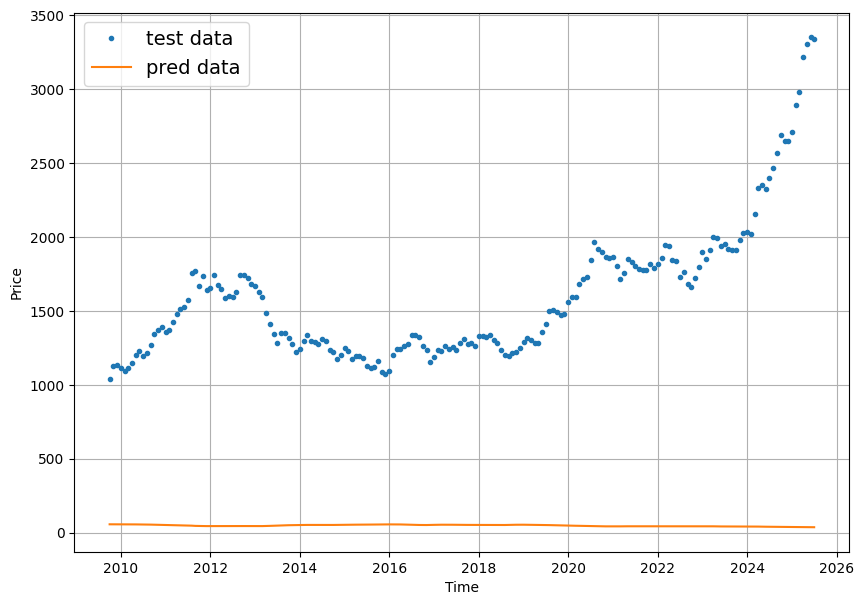

In [252]:
offset = 0
plt.figure(figsize=(10, 7))

create_time_series_plot(timesteps=test_df.index[-len(test_windows):], values=test_horizons[:, 0], start=offset, format='.', label="test data")
create_time_series_plot(timesteps=test_df.index[-len(test_windows):], values=y_preds, start=offset, format='-', label="pred data")


In [253]:
y_preds[-5:], test_horizons[-5:]

(array([38.5604  , 38.346916, 38.10307 , 37.887264, 37.662167],
       dtype=float32),
 array([[2983.25],
        [3217.64],
        [3309.49],
        [3352.66],
        [3340.15]]))